# **Forest Fire Area Prediction**

Importing packages

Quick Thanks to https://archive.ics.uci.edu/dataset/162/forest+fires for the public dataset

In [206]:
import pandas as pd
import tensorflow as tf
import keras
from keras import layers as ls
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv("forestfires.csv")
df.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0


In [3]:
df['area'] = np.log1p(df['area'])

In [4]:
df['area'] = np.sqrt(df['area'])  # Requires all data to be positive

Thought Process: The data was heavily skewed to zero, so by using log scale to make the distribution better for statistical modeling I used the log(1 + x) formula to handle the 0 values better.

Distribution of Forest Fires

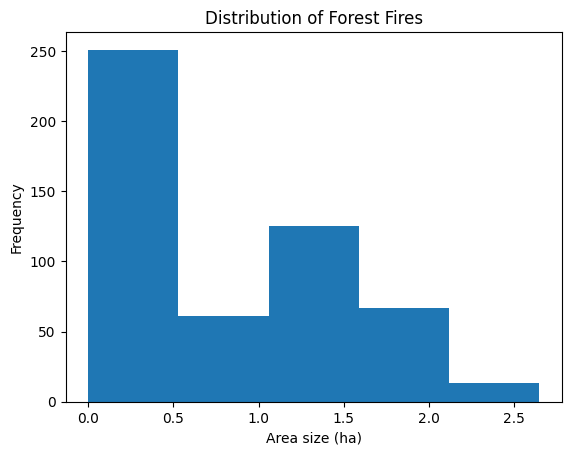

In [5]:
plt.hist(df['area'], bins = 5)
plt.xlabel('Area size (ha)')
plt.ylabel('Frequency')
plt.title("Distribution of Forest Fires")
plt.show()

In [71]:
threshold = 0.7
df['goal'] = df['area'] > threshold
df['goal'] = df['goal'].astype(int)

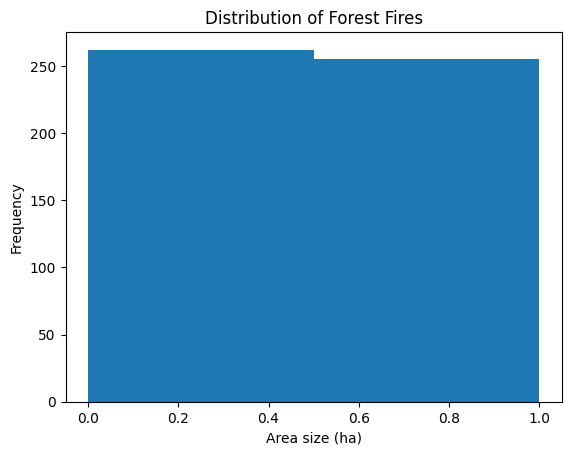

In [72]:
plt.hist(df['goal'], bins = 2)
plt.xlabel('Area size (ha)')
plt.ylabel('Frequency')
plt.title("Distribution of Forest Fires")
plt.show()

How often do forest fires occur in certain months?

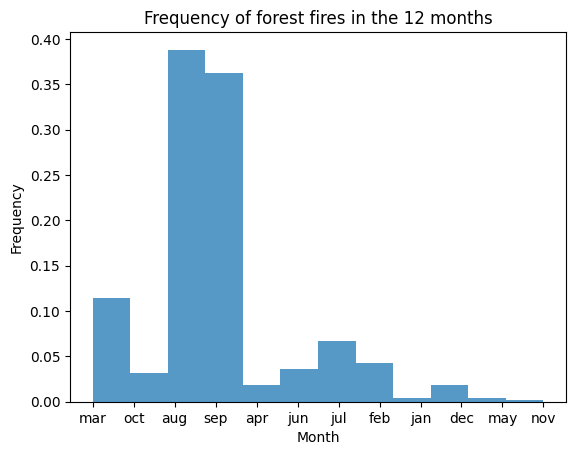

In [73]:
plt.hist(df['month'], bins=12, density=True, alpha=0.75)
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.title("Frequency of forest fires in the 12 months")
plt.show()

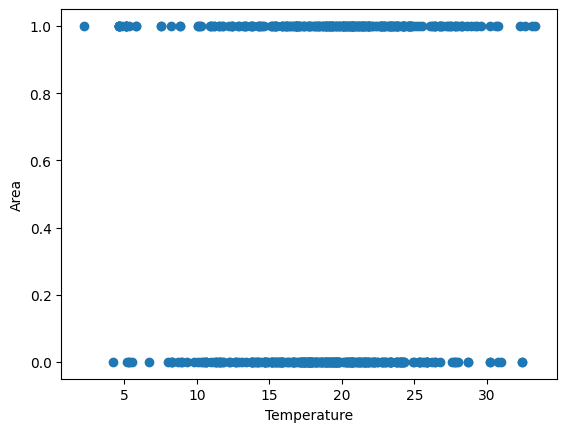

In [74]:
plt.scatter(df['temp'], df['goal'])
plt.xlabel('Temperature')
plt.ylabel('Area')
plt.show()

Hard to see a clear correlation, but the ML model should be able to find a correlation between many features

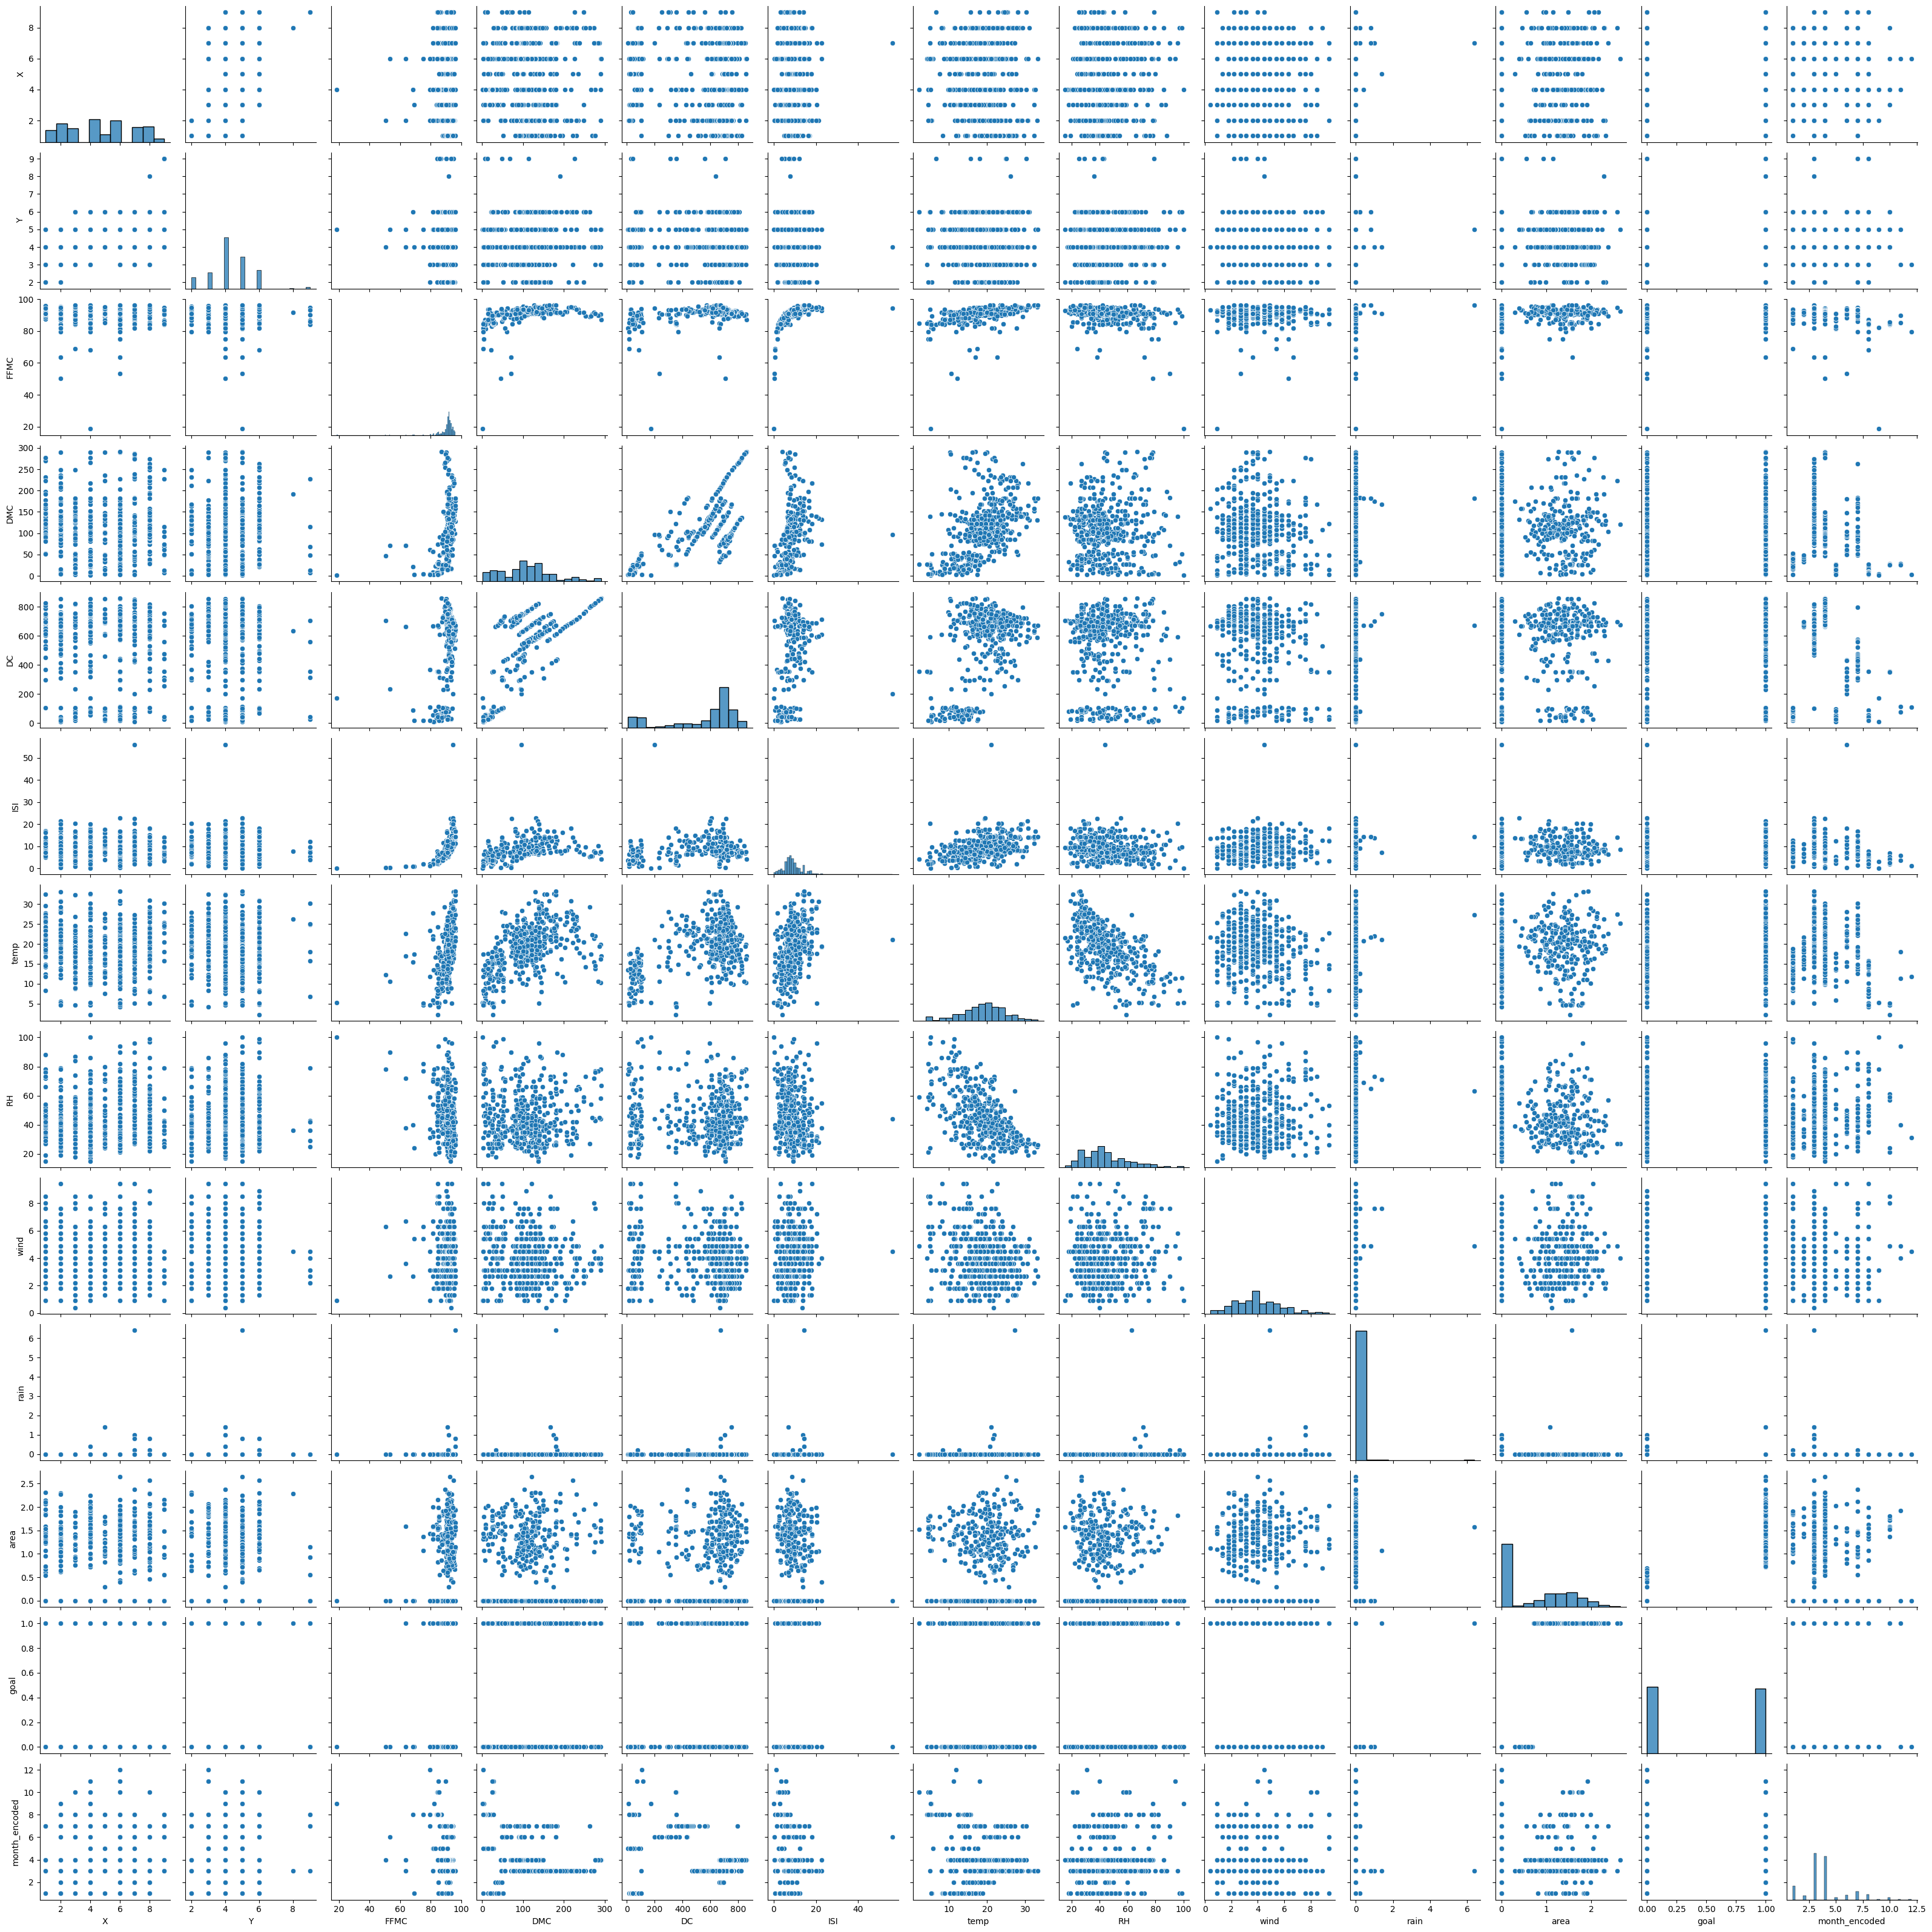

In [75]:
sns.pairplot(df)

Most interesting part is the second row where we can see the goal graph having no apparent correlation with any variable. However, these graphs tend to be miss leading as they don't show high level complexities between data

One-Hot Encode the months

In [76]:
df['month'].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [77]:
category_names = ['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov']
mapping_dict = {month: index + 1 for index, month in enumerate(category_names)}
df['month_encoded'] = df['month'].map(mapping_dict)


# Model Creation

In [181]:
inputs = ls.Input(shape=(len(df.drop(columns=['X', 'Y', 'month', 'day', 'area']).columns), ))

x = ls.Dense(10, activation='relu')(inputs)
x = ls.Dense(20, activation='relu')(x)
x = ls.Dense(10, activation='relu')(x)
x = ls.Dense(20, activation='relu')(x)

prediction = ls.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=prediction, name="forest_area_predictor")

model.summary()

Model: "forest_area_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 781 (3.05 KB)

 Trainable params: 781 (3.05 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
def custom_loss(y_true, y_pred):
    # Round the predictions
    y_pred = tf.round(y_pred)

    # Avoid division by zero and calculate weights inversely proportional to the target values
    weights = 1.0 / (y_true + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero

    # Calculate the squared differences
    loss = tf.square(y_true - y_pred) * weights * 100  # Scaling the loss
    
    return tf.reduce_mean(loss)

In [207]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['X', 'Y','month', 'day', 'area']),df['goal'] , random_state=104,test_size=0.15, shuffle=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=100)

predictions = model.predict(X_test)

test_scores = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7886 - loss: 0.3988
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9069 - loss: 0.3035 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8910 - loss: 0.3124 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8679 - loss: 0.3171 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8834 - loss: 0.3006 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8638 - loss: 0.3360 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9186 - loss: 0.2774 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9169 - loss: 0.2679 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8795 - loss: 0.2931 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8881 - loss: 0.3090 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9039 - loss: 0.2719 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

In [209]:
def custom_round(x):
    return np.floor(x + 0.5)

In [210]:
print(custom_round(predictions).flatten())
print([i for i in y_test])
print("Test loss:", np.mean(predictions.flatten() - y_test))
print("Test accuracy:",np.mean(predictions.flatten() == y_test))

[0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1.]
[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Test loss: -0.0018076436497354875
Test accuracy: 0.0


In [158]:
thresh = 0.5
predicted_labels = (predictions >= thresh).astype(int)
print([i for i in y_test])                                  
print(predicted_labels.flatten())

[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
[0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1
 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0
 0 0 1 1]


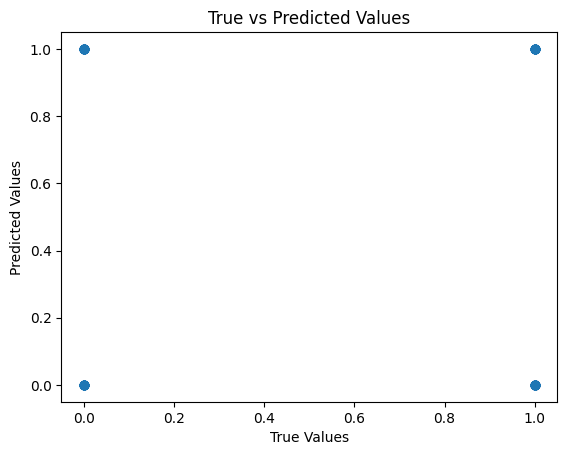

In [116]:
#plt.scatter(y_test, y_test)
plt.scatter(y_test, predicted_labels)
#plt.plot(y_test, predicted_labels, color='red', label='Line of Best Fit')  # Regression line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

Deep learning models for this specific task can be tricky because while they add more complexity to the task... there doesn't need to be as only 9 features exist.

# Random Forest Reggesorion Model

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [144]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

c:\Users\lordw\OneDrive\Documents\Hackathons\HowdyHack2024\tamuhack24\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [150]:
# Predictions
y_prob = logreg.predict(X_test)
predicted_labels_linreg = (y_prob >= thresh).astype(int)
predicted_labels_linreg = predicted_labels_linreg.flatten()
print([i for i in y_test])
print(predicted_labels_linreg)
print(logreg.score(X_test, y_test))

[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
[0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0
 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0
 1 0 0 1]
1.0


In [155]:
print([i for i in y_test])
print([1 if i > .5 else 0 for i in predicted_labels_linreg])

[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]


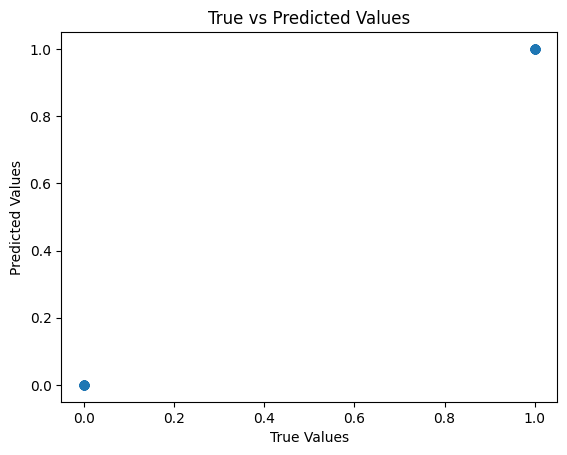

In [152]:
#plt.scatter(y_test, y_test)
plt.scatter(y_test, predicted_labels_linreg)
#plt.plot(y_test, predicted_labels, color='red', label='Line of Best Fit')  # Regression line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

In [163]:
import joblib

joblib.dump(logreg, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [166]:
predictions = logreg.predict(X_test)
print(predictions)
print([i for i in y_test])

[0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0
 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0
 1 0 0 1]
[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]


# Really really cool graphs!

Clarifying Points:
    - The sample dataset is small where n = 518, and while this may seem large for a feature selection of 9 it is in fact

In [169]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

How have forest fires progressed in the past years?

In [160]:
yearly = pd.read_csv("GlobalCO2Emissions.csv")
yearly.head(2)

,Year,Emissions
0,1750,0.03
1,1760,0.03


CO2 emissions are going up around the world, and because of this wildlife, agriculture, and many other forms of lifestyle of constricted. This can be a huge issue as well to the environment as we face more volatile temperatures with effects like the polar ice caps melting. Additionally, there are side effects like the smoke from a fire. This smoke can cause air pollution causing entire cities to be devasted as breathing the air in the dense zones can prove fatal due to fine dust particles.

# *Fire Detection Algorithm*

Import packages

In [ ]:
import cv2


import opencv as oc